In [1]:
# stdlib
import time

# third party
import jwt
from matplotlib import pyplot as plt
import numpy as np
import torch as th
from torchvision import datasets
from torchvision import transforms

# syft absolute
import syft as sy
from syft.federated.fl_client import FLClient
from syft.federated.fl_job import FLJob
from syft.federated.model_centric_fl_client import ModelCentricFLClient
from syft.util import get_root_data_path

In [2]:
th.random.manual_seed(42)

# Train FL model

## Create Auth token

In [3]:
def read_file(fname):
    with open(fname, "r") as f:
        return f.read()

In [4]:
private_key = read_file("example_rsa").strip()
public_key = read_file("example_rsa.pub").strip()

In [5]:
auth_token = jwt.encode({}, private_key, algorithm="RS256").decode("ascii")

In [6]:
# PyGrid Node address
gridAddress = "ws://localhost:7000"

# Hosted model name/version
model_name = "mnist"
model_version = "1.0"

## Define Federated Learning Job callbacks

In [7]:
# TorchVision hotfix https://github.com/pytorch/vision/issues/3549

datasets.MNIST.resources = [
    (
        "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
datasets.MNIST(get_root_data_path(), train=True, download=True)
datasets.MNIST(get_root_data_path(), train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/hinnes/.syft/data
    Split: Test

In [8]:
tfs = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_set = datasets.MNIST(get_root_data_path(), train=True, download=True, transform=tfs)

In [9]:
cycles_log = []
status = {"ended": False}

# Called when client is accepted into FL cycle
def on_accepted(job: FLJob):
    print(f"Accepted into cycle {len(cycles_log) + 1}!")

    cycle_params = job.client_config
    batch_size, max_updates = cycle_params["batch_size"], cycle_params["max_updates"]
    training_plan, model_params = job.plans["training_plan"], job.model
    losses, accuracies = [], []

    train_loader = th.utils.data.DataLoader(
        train_set, batch_size=batch_size, drop_last=True, shuffle=True
    )

    for batch_idx, (x, y) in enumerate(train_loader):
        y = th.nn.functional.one_hot(y, 10)
        (model_params,) = training_plan(xs=x, ys=y, params=model_params)

        if batch_idx >= max_updates - 1:
            break

    job.report(model_params)
    # Save losses/accuracies from cycle
    cycles_log.append((losses, accuracies))


# Called when the client is rejected from cycle
def on_rejected(job: FLJob, timeout):
    if timeout is None:
        print(f"Rejected from cycle without timeout (this means FL training is done)")
    else:
        print(f"Rejected from cycle with timeout: {timeout}")
    status["ended"] = True


# Called when error occured
def on_error(job: FLJob, error: Exception):
    print(f"Error: {error}")
    status["ended"] = True

In [10]:
def create_client_and_run_cycle():
    client = FLClient(url=gridAddress, auth_token=auth_token, secure=False)
    client.worker_id = client.grid_worker.authenticate(
        client.auth_token, model_name, model_version
    )["data"]["worker_id"]
    job = client.new_job(model_name, model_version)

    # Set event handlers
    job.add_listener(job.EVENT_ACCEPTED, on_accepted)
    job.add_listener(job.EVENT_REJECTED, on_rejected)
    job.add_listener(job.EVENT_ERROR, on_error)

    # Shoot!
    job.start()

In [11]:
while not status["ended"]:
    create_client_and_run_cycle()
    time.sleep(1)

Accepted into cycle 1!
Accepted into cycle 2!
Accepted into cycle 3!
Accepted into cycle 4!
Accepted into cycle 5!
Accepted into cycle 6!
Accepted into cycle 7!
Accepted into cycle 8!
Accepted into cycle 9!
Accepted into cycle 10!
Accepted into cycle 11!
Accepted into cycle 12!
Accepted into cycle 13!
Accepted into cycle 14!
Accepted into cycle 15!
Accepted into cycle 16!
Accepted into cycle 17!
Accepted into cycle 18!
Accepted into cycle 19!
Accepted into cycle 20!
Accepted into cycle 21!
Accepted into cycle 22!
Accepted into cycle 23!
Accepted into cycle 24!
Accepted into cycle 25!
Accepted into cycle 26!
Accepted into cycle 27!
Accepted into cycle 28!
Accepted into cycle 29!
Rejected from cycle without timeout (this means FL training is done)


# Download trained model 

In [12]:
grid_address = "localhost:7000"
grid = ModelCentricFLClient(address=grid_address, secure=False)
grid.connect()

In [13]:
trained_params = grid.retrieve_model(model_name, model_version)

# Inference

In [14]:
class MLP(sy.Module):
    def __init__(self, torch_ref):
        super().__init__(torch_ref=torch_ref)
        self.l1 = self.torch_ref.nn.Linear(784, 100)
        self.a1 = self.torch_ref.nn.ReLU()
        self.l2 = self.torch_ref.nn.Linear(100, 10)

    def forward(self, x):
        x_reshaped = x.view(-1, 28 * 28)
        l1_out = self.a1(self.l1(x_reshaped))
        l2_out = self.l2(l1_out)
        return l2_out

In [15]:
def set_params(model, params):
    for p, p_new in zip(model.parameters(), params):
        p.data = p_new.data

In [16]:
def test(test_loader, model):
    correct = []
    model.eval()
    for data, target in test_loader:
        output = model(data)
        _, pred = th.max(output, 1)
        correct.append(th.sum(np.squeeze(pred.eq(target.data.view_as(pred)))))
    acc = sum(correct) / len(test_loader.dataset)
    return acc

In [17]:
model = MLP(th)
set_params(model, trained_params)

In [18]:
tfs = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_test = datasets.MNIST(get_root_data_path(), train=False, transform=tfs)
test_loader = th.utils.data.DataLoader(
    mnist_test, batch_size=32, shuffle=True, pin_memory=True
)

In [19]:
print(f"accuracy: {test(test_loader, model):.2F}")

accuracy: 0.86


In [20]:
def show_predictions(test_loader, model, n=6):
    xs, ys = next(iter(test_loader))
    preds = model(xs).detach()

    fig, axs = plt.subplots(1, n, figsize=(16, 8))
    for i in range(n):
        ax = axs[i]
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_xlabel(f"prediction: {np.argmax(preds[i])}, actual: {ys[i]}")
        ax.imshow(xs[i].reshape((28, 28)))

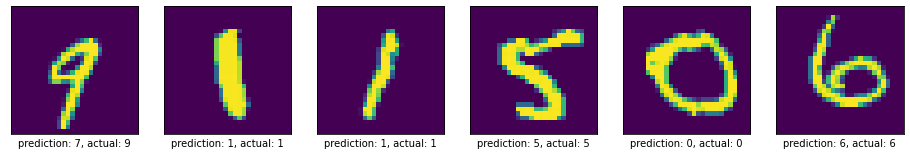

In [21]:
show_predictions(test_loader, model)